# Facial Verification

### Setup

In [1]:
# installing dependencies
!pip install tensorflow tensorflow-gpu opencv-python matplotlib

  Using cached tensorflow-gpu-2.12.0.tar.gz (2.6 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Using cached python_version-0.0.2-py2.py3-none-any.whl (3.4 kB)
  Running setup.py clean for tensorflow-gpu
Failed to build tensorflow-gpu


  error: subprocess-exited-with-error
  
  python setup.py bdist_wheel did not run successfully.
  exit code: 1
  
  [18 lines of output]
  Traceback (most recent call last):
    File "<string>", line 2, in <module>
    File "<pip-setuptools-caller>", line 34, in <module>
    File "C:\Users\rckzs\AppData\Local\Temp\pip-install-oahfx5cf\tensorflow-gpu_b4e6cda44b9946f290b39a1e3c4e747f\setup.py", line 37, in <module>
      raise Exception(TF_REMOVAL_WARNING)
  Exception:
  
  The "tensorflow-gpu" package has been removed!
  
  Please install "tensorflow" instead.
  
  Other than the name, the two packages have been identical
  since TensorFlow 2.1, or roughly since Sep 2019. For more
  information, see: pypi.org/project/tensorflow-gpu
  
  
  [end of output]
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for tensorflow-gpu
ERROR: Could not build wheels for tensorflow-gpu, which is required to install pyproject.toml-

In [ ]:
!pip install opencv-python

In [1]:
# importing standard dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os
import random

In [2]:
# importing deeplearning dependencies - functional API
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

### Setting GPU Growth

In [3]:
# setting up GPU to avoid OOM errors.
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu,True)

In [4]:
gpus

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

### Seting up Folder Structure

In [110]:
# acchor - input image
# verification image - pos and neg. image
# PATH setup
POS_PATH = os.path.join('data','pos')
NEG_PATH = os.path.join('data','neg')
ANC_PATH = os.path.join('data','anchor')

In [111]:
# making directories
os.makedirs(POS_PATH)
os.makedirs(NEG_PATH)
os.makedirs(ANC_PATH)

### Collecting Positives and Anchors

In [ ]:
# Anchors from camera.
# positive from camera.
# negative from labelled faces in the wild.

In [ ]:
# negative 
# http://vis-www.cs.umass.edu/lfw/
!tar -xf lfw.tgz

In [112]:
# moving negative images (lfw) to req repo
for directory in os.listdir('lfw'):
    for file in os.listdir(os.path.join('lfw',directory)):
        EX_PATH = os.path.join('lfw',directory,file)
        NEW_PATH = os.path.join(NEG_PATH,file)
        os.replace(EX_PATH,NEW_PATH)

In [113]:
# importing uuid to generate unique image names
import uuid

In [115]:
# for positive and anchor, accessing camera using opencv
# Establishing a connection with cam.
cap = cv2.VideoCapture(0)
# looping through frames.
while cap.isOpened():
    ret, frame = cap.read()
    # to 250x1qq250 shape
    frame = frame[75:325,225:475,:]
    # collecting anchors
    if cv2.waitKey(1) & 0XFF==ord('a'):
        anc_name = os.path.join(ANC_PATH,'{}.jpg'.format(uuid.uuid1()))
        cv2.imwrite(anc_name,frame)
    # collect positives
    if cv2.waitKey(1) & 0XFF==ord('p'):
        pos_name = os.path.join(POS_PATH,'{} .jpg'.format(uuid.uuid1()))
        cv2.imwrite(pos_name,frame)
    
    # show screen
    cv2.imshow('Images',frame)
    
    if cv2.waitKey(1) & 0XFF==ord('q'):
        break
# Realse the cam.
cap.release()
# close image frame.
cv2.destroyAllWindows()

In [116]:
frame

array([[[139, 142, 155],
        [139, 140, 154],
        [139, 140, 154],
        ...,
        [133, 139, 132],
        [132, 138, 131],
        [133, 139, 132]],

       [[139, 142, 155],
        [141, 143, 156],
        [141, 143, 156],
        ...,
        [135, 142, 134],
        [134, 141, 133],
        [132, 138, 131]],

       [[141, 144, 157],
        [141, 143, 156],
        [142, 144, 157],
        ...,
        [135, 142, 134],
        [134, 141, 133],
        [132, 138, 131]],

       ...,

       [[255, 253, 255],
        [255, 253, 255],
        [255, 252, 255],
        ...,
        [ 70,  53, 100],
        [ 68,  50,  98],
        [ 75,  57, 106]],

       [[255, 252, 255],
        [255, 251, 255],
        [247, 235, 252],
        ...,
        [ 72,  53,  98],
        [ 75,  55, 100],
        [ 78,  59, 104]],

       [[254, 242, 255],
        [199, 183, 203],
        [156, 138, 158],
        ...,
        [ 70,  52,  90],
        [ 73,  54,  93],
        [ 74,  54,  93]]

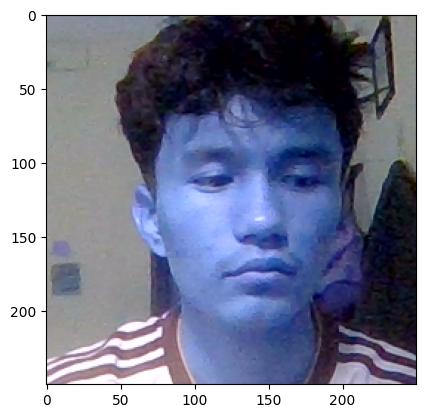

In [117]:
plt.imshow(frame)

In [118]:
frame.shape

(250, 250, 3)

## Load and Preprocess images

In [119]:
# get image dirs
anchor = tf.data.Dataset.list_files(ANC_PATH+'/*.jpg').take(300)
positive = tf.data.Dataset.list_files(POS_PATH+'/*.jpg').take(300)
negative = tf.data.Dataset.list_files(NEG_PATH+'/*.jpg').take(300)

In [120]:
# normalize, resize
def preprocess(path):
    # read the image from filepath
    byte_image = tf.io.read_file(path)
    # loading the image 
    image = tf.io.decode_jpeg(byte_image)
    # resizing to 100x100
    image = tf.image.resize(image,(100,100))
    # normalization.(scaling)
    image = image/255.0
    return image

In [121]:
# creating labelled dataset
positives = tf.data.Dataset.zip((anchor,positive,tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor,negative,tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [122]:
data

<ConcatenateDataset shapes: ((), (), ()), types: (tf.string, tf.string, tf.float32)>

In [123]:
# preprocessing.
def preprocess2(input_image, validation_image, label):
    return (preprocess(input_image),preprocess(validation_image),label)

In [124]:
# dataloader pipeline
data = data.map(preprocess2)
data = data.cache()
data = data.shuffle(buffer_size = 1024)

In [125]:
data
# return shuffled data set of (anchor image, positive/negative image, label)

<ShuffleDataset shapes: ((100, 100, None), (100, 100, None), ()), types: (tf.float32, tf.float32, tf.float32)>

In [126]:
# testing if works.
sample = data.as_numpy_iterator()

In [127]:
samp = sample.next()

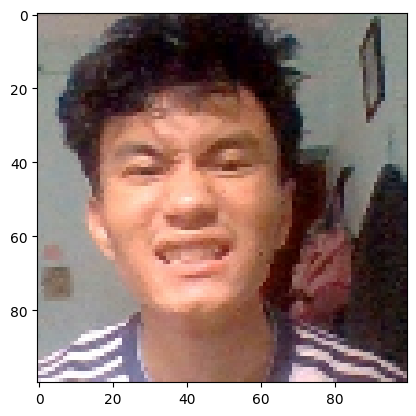

In [128]:
# anchor image.
plt.imshow(samp[0])

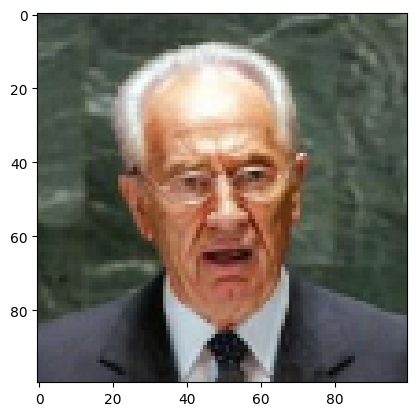

In [129]:
# positive or negative image.
plt.imshow(samp[1])

In [130]:
# respective image.
samp[2]

0.0

In [131]:
# train-test split.
train_data = data.take(round(len(data)*0.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [132]:
test_data = data.skip(round(len(data)*0.7))
test_data = test_data.take(round(len(data)*0.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

## Building a siamese NN

In [133]:
inp = Input(shape=(100,100,3),name='input_image')

In [134]:
conv1 = Conv2D(64,(10,10),activation='relu')(inp)

In [135]:
conv1

<KerasTensor: shape=(None, 91, 91, 64) dtype=float32 (created by layer 'conv2d_4')>

In [136]:
mp1 = MaxPooling2D(64,(2,2),padding='same')(conv1)

In [137]:
mp1 # feature maps 

<KerasTensor: shape=(None, 46, 46, 64) dtype=float32 (created by layer 'max_pooling2d_3')>

In [138]:
conv2 = Conv2D(128,(7,7),activation='relu')(mp1)
mp2 = MaxPooling2D(64,(2,2),padding='same')(conv2)

conv3 = Conv2D(128,(4,4),activation='relu')(mp2)
mp3 = MaxPooling2D(64,(2,2),padding='same')(conv3)

conv4 = Conv2D(256,(4,4),activation='relu')(mp3)
flat1= Flatten()(conv4)
dense1= Dense(4096,activation='sigmoid')(flat1)

In [139]:
embedding = Model(inputs=[inp], outputs=[dense1], name='embedding')

In [140]:
# embedding layer.
def embed():
    inp = Input(shape=(100,100,3),name = 'input_image')
    
    conv1 = Conv2D(64,(10,10),activation='relu')(inp)
    mp1 = MaxPooling2D(64,(2,2),padding='same')(conv1)
    
    conv2 = Conv2D(128,(7,7),activation='relu')(mp1)
    mp2 = MaxPooling2D(64,(2,2),padding='same')(conv2)
    
    conv3 = Conv2D(128,(4,4),activation='relu')(mp2)
    mp3 = MaxPooling2D(64,(2,2),padding='same')(conv3)
    
    conv4 = Conv2D(256,(4,4),activation='relu')(mp3)
    flat1= Flatten()(conv4)
    dense1= Dense(4096,activation='sigmoid')(flat1)
    
    return Model(inputs=[inp], outputs=[dense1], name='embedding')

In [141]:
embedding.summary()

Model: "embedding"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_image (InputLayer)     [(None, 100, 100, 3)]     0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 91, 91, 64)        19264     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 46, 46, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 40, 40, 128)       401536    
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 20, 20, 128)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 17, 17, 128)       262272    
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 9, 9, 128)         0 

In [143]:
embedding = embed()

In [144]:
embedding.summary()

Model: "embedding"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_image (InputLayer)     [(None, 100, 100, 3)]     0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 91, 91, 64)        19264     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 46, 46, 64)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 40, 40, 128)       401536    
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 20, 20, 128)       0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 17, 17, 128)       262272    
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 9, 9, 128)         0 

In [145]:
# L1 distance to compare
class L1Dist(Layer):
    def __init__(self,**kwargs):
        super().__init__()
    def call(self,input_embedding,validation_embedding):
        return tf.math.abs(input_embedding-validation_embedding)

In [146]:
l1 = L1Dist()

In [147]:
# Building siamese model
def siamese_model():
    #inputs
    input_image = Input(name='input_img',shape=(100,100,3))
    validation_image = Input(name='validation_img',shape=(100,100,3))
    # passing through embedding layer
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image),embedding(validation_image))
    
    classifier = Dense(1,activation='sigmoid')(distances)
    
    return Model(inputs=[input_image,validation_image],outputs = classifier,name='siameseNN')

In [148]:
siamese_model = siamese_model()

In [149]:
siamese_model.summary()

Model: "siameseNN"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_img (InputLayer)          [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
validation_img (InputLayer)     [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
embedding (Functional)          (None, 4096)         38960448    input_img[0][0]                  
                                                                 validation_img[0][0]             
__________________________________________________________________________________________________
distance (L1Dist)               (None, 4096)         0           embedding[0][0]          

## Training a Siamese NN

In [150]:
# setting up loss function and optimizer
binary_cross_loss = tf.losses.BinaryCrossentropy()


In [151]:
opt = tf.keras.optimizers.Adam(1e-4)

In [152]:
# extablising checkpoints
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir,'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

In [153]:
@tf.function
def train_step(batch):
    
    # Record all of our operations 
    with tf.GradientTape() as tape:     
        # Get anchor and positive/negative image
        X = batch[:2]
        # Get label
        y = batch[2]
        
        # Forward pass
        yhat = siamese_model(X, training=True)
        # Calculate loss
        loss = binary_cross_loss(y, yhat)
    print(loss)
        
    # Calculate gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    
    # Calculate updated weights and apply to siamese model
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
    
    # Return loss
    return loss

In [154]:
def train(data, EPOCHS):
    # Loop through epochs
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
        
        # Loop through each batch
        for idx, batch in enumerate(data):
            # Run train step here
            train_step(batch)
            progbar.update(idx+1)
        
        # Save checkpoints
        if epoch % 10 == 0: 
            checkpoint.save(file_prefix=checkpoint_prefix)

In [155]:
# training the model
EPOCHS = 50

In [156]:
train(train_data,EPOCHS)


 Epoch 1/50
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
27/27 [==============================] - 8s 259ms/step

 Epoch 2/50
27/27 [==============================] - 7s 253ms/step

 Epoch 3/50
27/27 [==============================] - 7s 251ms/step

 Epoch 4/50
27/27 [==============================] - 7s 251ms/step

 Epoch 5/50
27/27 [==============================] - 7s 251ms/step

 Epoch 6/50
27/27 [==============================] - 7s 252ms/step

 Epoch 7/50
27/27 [==============================] - 7s 253ms/step

 Epoch 8/50
27/27 [==============================] - 7s 254ms/step

 Epoch 9/50
27/27 [==============================] - 7s 254ms/step

 Epoch 10/50
27/27 [==============================] - 7s 254ms/step

 Epoch 11/50
27/27 [==============================] - 7s 262ms/step

 Epoch 12/50
27/27 [==============================] - 7s 254ms/step

 Epoch 13/50
27/27 [======

## Evaluation 

In [157]:
# import metrics
from tensorflow.keras.metrics import Precision, Recall

In [158]:
test_input,test_val,y_true = test_data.as_numpy_iterator().next()

In [159]:
len(test_input)

16

In [160]:
len(test_val)

16

In [161]:
y_true

array([0., 1., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0.],
      dtype=float32)

In [162]:
y_hat = siamese_model.predict([test_input,test_val])

In [163]:
y_hat

array([[5.3015509e-11],
       [9.9983680e-01],
       [9.9987996e-01],
       [3.1475391e-09],
       [7.8814646e-12],
       [1.3183786e-09],
       [3.9980744e-11],
       [3.7489208e-08],
       [9.9999678e-01],
       [1.0000000e+00],
       [1.7916710e-08],
       [2.0775086e-10],
       [9.9982977e-01],
       [7.8108136e-12],
       [3.5823882e-11],
       [2.6050679e-11]], dtype=float32)

In [164]:
# Post processing the result
[1 if pred>0.5 else 0 for pred in y_hat]

[0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0]

In [165]:
# creating a metric obj.
m = Recall()
# calculating the recall value.
m.update_state(y_true,y_hat)
# returns result
m.result().numpy()

1.0

In [166]:
# Precision
m2 = Precision()
m2.update_state(y_true,y_hat)
m.result().numpy()

1.0

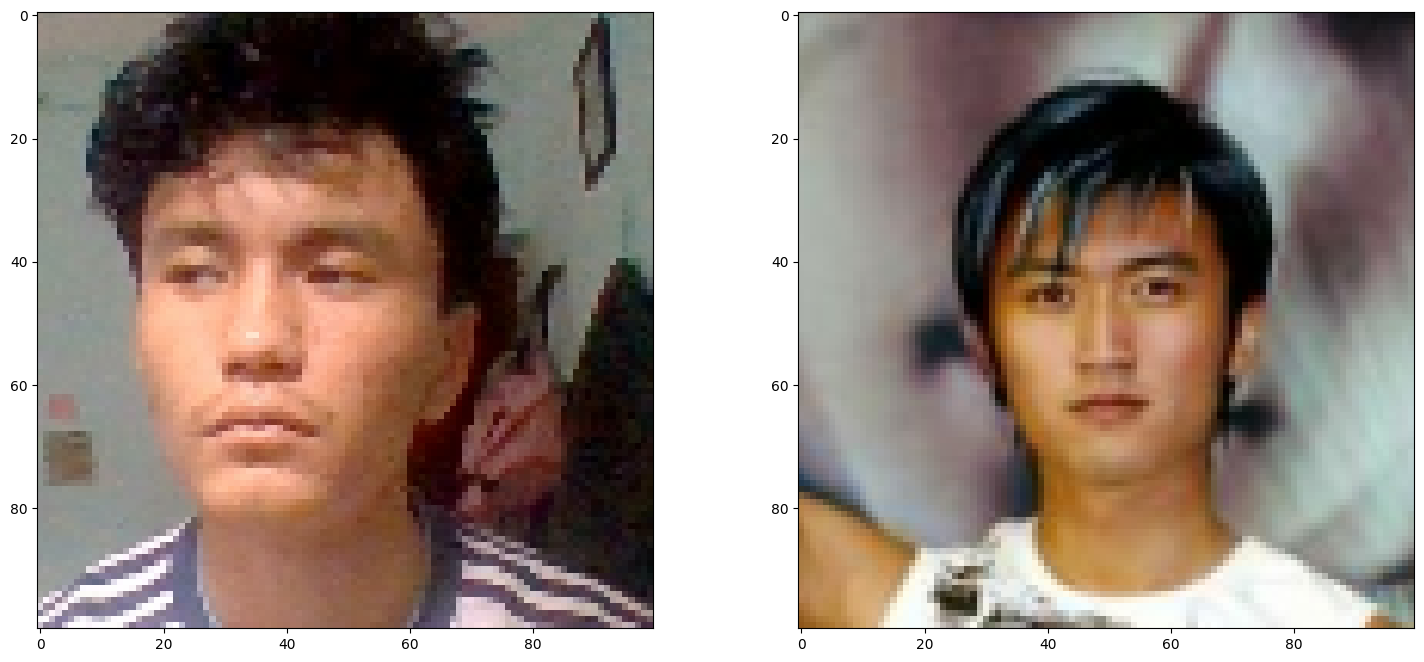

In [167]:
# visualize the result.
plt.figure(figsize=(18,8))
plt.subplot(1,2,1)
plt.imshow(test_input[7])
plt.subplot(1,2,2)
plt.imshow(test_val[7])
plt.show()

## Saving Model

In [168]:
siamese_model.save('siamesemodel3.h5')

In [169]:
model3 = tf.keras.models.load_model('siamesemodel3.h5',
                                  custom_objects={'L1Dist':L1Dist,'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

## Real Time Test

In [170]:
# Verification function.
def verify(model, detection_threshold, verification_threshold):
    results = []
    for image in os.listdir(os.path.join('application_data','verification_image')):
        input_img = preprocess(os.path.join('application_data','input_image','input_image.jpg'))
        validation_img = preprocess(os.path.join('application_data','verification_image',image))
        
        result = model.predict(list(np.expand_dims([input_img,validation_img],axis=1)))
        results.append(result)
    
    detection = np.sum(np.array(results)>detection_threshold)
    print(detection)
    verification = detection / len(os.listdir(os.path.join('application_data','verification_image')))
    verified = verification>verification_threshold
    
    return  results, verified

In [187]:
# real time 
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    frame = frame[75:325,225:475,:]
    cv2. imshow('Verification', frame)
    
    # Trigger
    if cv2.waitKey(10) & 0xFF == ord('v'):
        # saving input image
        cv2.imwrite(os.path.join('application_data','input_image','input_image.jpg'),frame)
        results, verified = verify(model3, 0.9,0.50)
        print(verified)
    if cv2.waitKey(5) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

0
False
36
True
36
True
35
True
33
True
44
True


In [188]:
np.squeeze(results)

array([1.0000000e+00, 1.0000000e+00, 1.0000000e+00, 1.0000000e+00,
       1.0000000e+00, 1.0000000e+00, 1.0000000e+00, 1.0000000e+00,
       1.0000000e+00, 1.0000000e+00, 1.0000000e+00, 1.0000000e+00,
       1.0000000e+00, 9.9999988e-01, 1.0000000e+00, 1.0000000e+00,
       1.0000000e+00, 9.9999988e-01, 1.0000000e+00, 9.9999976e-01,
       9.9999273e-01, 9.9999130e-01, 9.9997509e-01, 9.9999845e-01,
       1.0000000e+00, 1.0000000e+00, 1.0000000e+00, 1.0000000e+00,
       1.0000000e+00, 1.0000000e+00, 1.0000000e+00, 1.0000000e+00,
       1.0000000e+00, 1.0000000e+00, 1.0000000e+00, 9.9966908e-01,
       6.1757694e-04, 9.9999976e-01, 9.9994326e-01, 9.9973518e-01,
       9.9912113e-01, 9.9985540e-01, 3.2454413e-01, 1.7915212e-04,
       8.6524850e-03, 2.8623067e-04, 6.2002206e-01, 9.5554835e-01,
       9.9990833e-01, 9.9985743e-01], dtype=float32)